# Analyse des séries temporelles avec Python

## Ouverture des jeux de données et pre-processing

### Importation des packages

In [112]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns



### Ouverture du fichier

In [77]:
# Chargement du fichier CSV en sautant les 3 premières lignes
data_wind_na = pd.read_csv('Data_region/ninja_wind_na_corrected.csv', skiprows=3)

# Affichage des premières lignes du DataFrame pour vérifier
print(data_wind_na.size)
data_wind_na.head()

26280


,time,local_time,electricity
0,2019-01-01 00:00,2019-01-01 01:00,0.130
1,2019-01-01 01:00,2019-01-01 02:00,0.146
2,2019-01-01 02:00,2019-01-01 03:00,0.153
3,2019-01-01 03:00,2019-01-01 04:00,0.158
4,2019-01-01 04:00,2019-01-01 05:00,0.148


### Représentation graphique

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


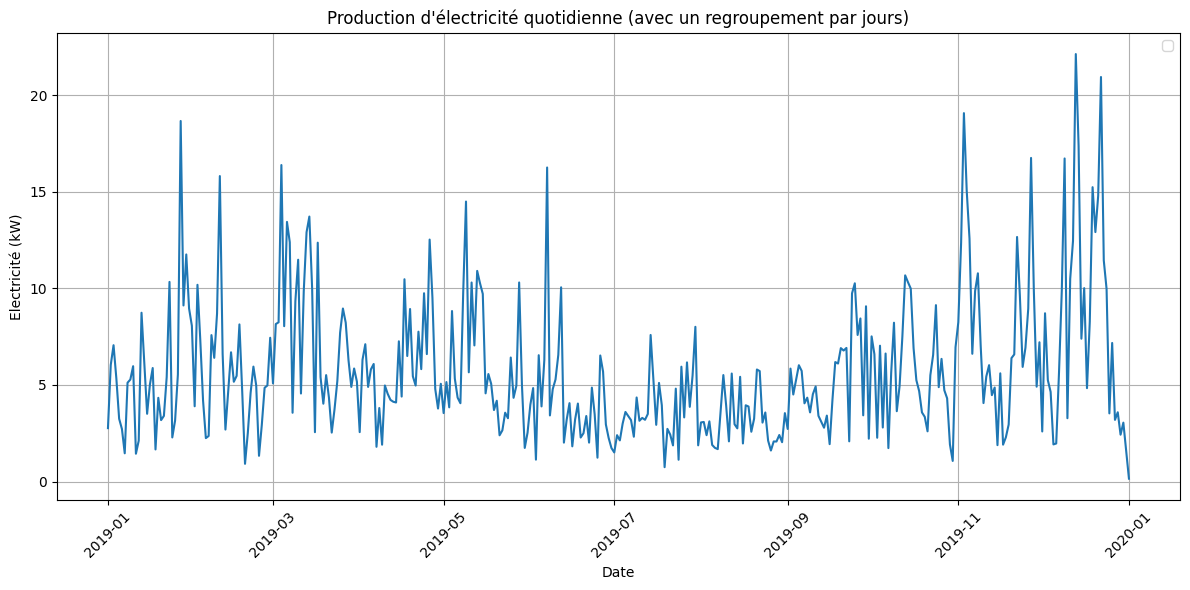

In [61]:
# Conversion des colonnes de temps en datetime
data_wind_na['time'] = pd.to_datetime(data_wind_na['time'])
data_wind_na['local_time'] = pd.to_datetime(data_wind_na['local_time'])

# Regroupement des données par jour en ne sommant que la colonne 'electricity'
df_daily_fixed = data_wind_na.set_index('local_time')['electricity'].resample('D').sum()

# Création d'un graphique de série temporelle quotidienne corrigée
plt.figure(figsize=(12, 6))
plt.plot(df_daily_fixed.index, df_daily_fixed)
plt.title('Production d\'électricité quotidienne (avec un regroupement par jours)')
plt.xlabel('Date')
plt.ylabel('Electricité (kW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

## Etude des séries temporelles

### Décompsition d'une série temporelle

Le principe de la décomposition des séries temporelles est de découper les séries originales en plusieurs composants indépendants : tendance, saisonnalité, cycle et bruit.

Le problème est qu'ici, nous n'avons pas de "motif" qui se répète, ce qui rend la décomposition plus difficile. 

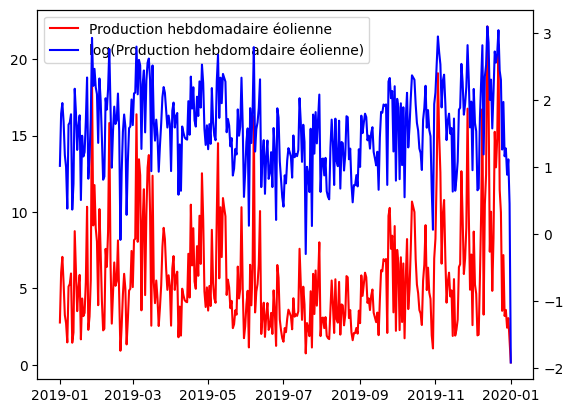

In [62]:
y = np.log(df_daily_fixed)

# création d'un graphique avec la série originale
fig, ax = plt.subplots()
ln1 = ax.plot(df_daily_fixed, c='r', label="Production hebdomadaire éolienne")

# création d'un graphique avec la série log en conservent le même axe des abscisses
ax2 = ax.twinx()
ln2 = ax2.plot(y, c='b', label="log(Production hebdomadaire éolienne)")

# ajout de la légende
lns = ln1 + ln2
labels=[l.get_label() for l in lns]
ax.legend(lns, labels)

### La tendance 

On a présenté dans le premier post une façon de visualiser la tendance en lissant la courbe à l'aide des moyennes mobiles sur une fenêtre glissante d'observations. Lorsqu'on choisit différentes tailles de fenêtres glissantes, on obtient les résultats suivants. Le principe revient à faire une moyenne locale pondérée des termes.

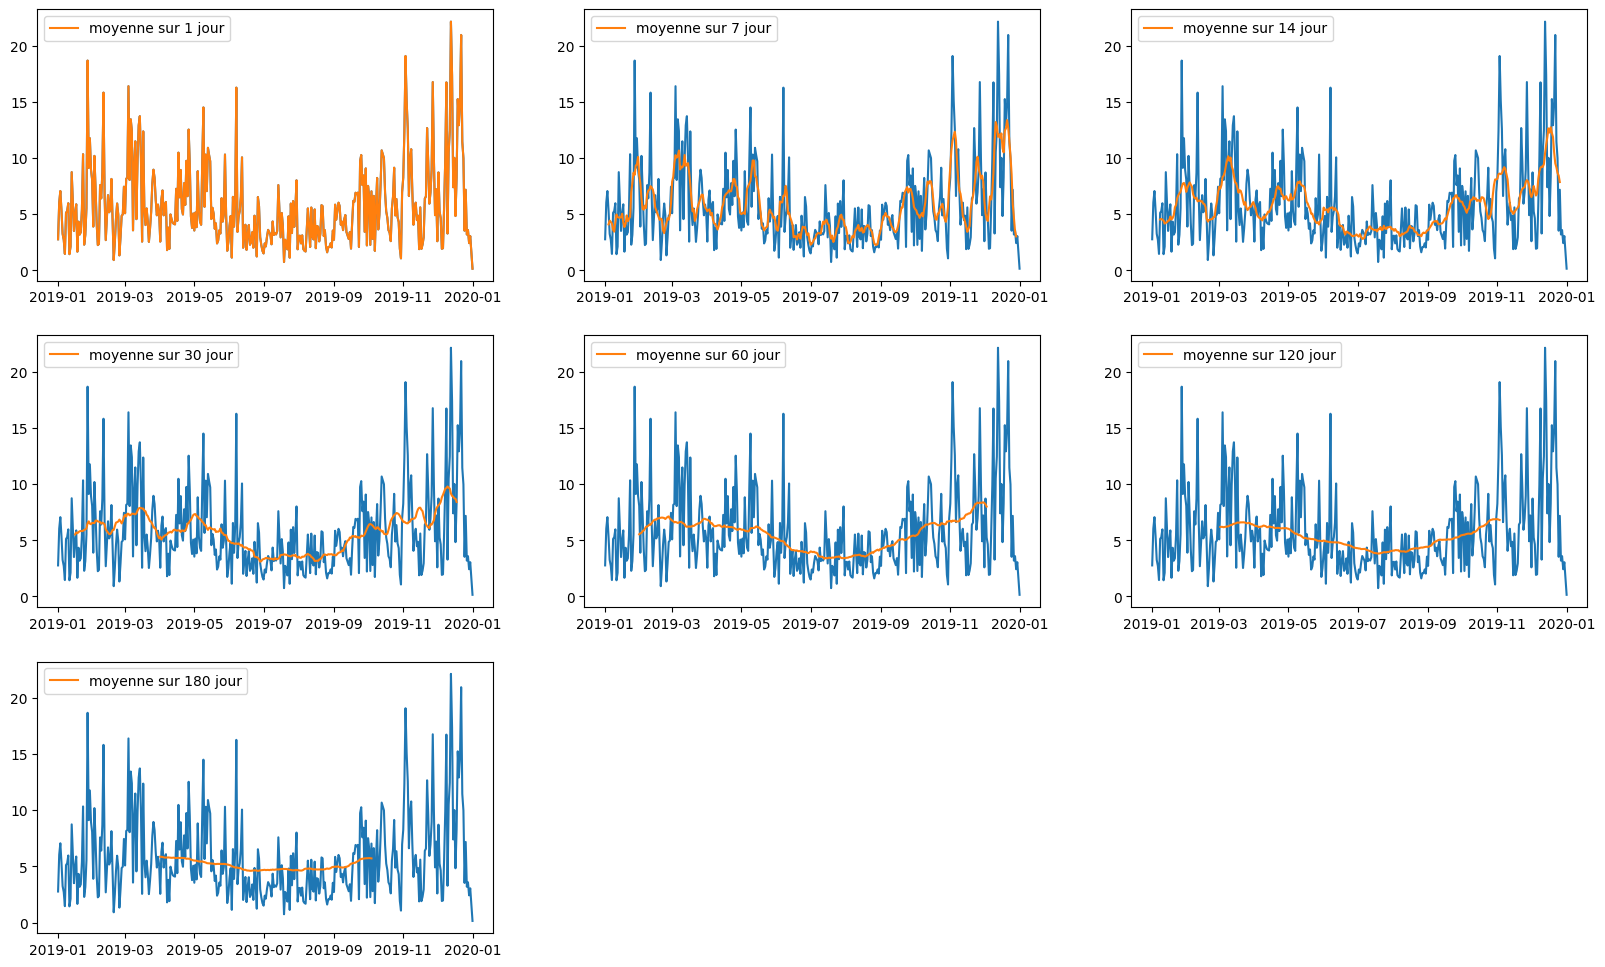

In [64]:
win = [1, 7, 14, 30, 60, 120, 180] # fenêtre d'observation (en nombre de semaines)
fig = plt.figure(figsize=(20,12))

for i in range(len(win)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(df_daily_fixed)
    ax.plot(df_daily_fixed.rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} jour")
    ax.legend()

On n'observe pas forcément de tendance croissnate ou de tendance linéaire.

### La saisonnalité

La saisonnalité désigne les tendances hebdomadaires, mensuelles, trimestrielles ou annuelles. Ce sont les motifs qui se répètent sur une durée. Il semble qu'on n'ait pas forcément de saisonnalité . Une manière visuelle de vérifier l'effet saisonnier est de tracer une courbe pour une année en prenant les semaines comme abscisses et visualiser ainsi la répartition des productions éoliennes au cours de l'année.

In [78]:
df = data_wind_na
df.drop('local_time', axis=1, inplace=True)

df.head()

,time,electricity
0,2019-01-01 00:00,0.130
1,2019-01-01 01:00,0.146
2,2019-01-01 02:00,0.153
3,2019-01-01 03:00,0.158
4,2019-01-01 04:00,0.148


In [83]:
df['time'] = pd.to_datetime(df['time'])

df['date'] = df['time'].dt.date
daily_production = df.groupby('date')['electricity'].sum().reset_index()

# Calculer le numéro de semaine et le jour de la semaine
daily_production['week_of_year'] = pd.to_datetime(daily_production['date']).dt.isocalendar().week
daily_production['day_of_week'] = pd.to_datetime(daily_production['date']).dt.dayofweek

# Afficher les premières lignes pour vérification
daily_production.head(10)

,date,electricity,week_of_year,day_of_week
0,2019-01-01,2.914,1,1
1,2019-01-02,6.159,1,2
2,2019-01-03,7.032,1,3
3,2019-01-04,5.291,1,4
4,2019-01-05,3.145,1,5
5,2019-01-06,2.794,1,6
6,2019-01-07,1.309,2,0
7,2019-01-08,5.278,2,1
8,2019-01-09,5.440,2,2
9,2019-01-10,5.836,2,3


In [93]:
daily_production['week_of_year'].shape[0]

365

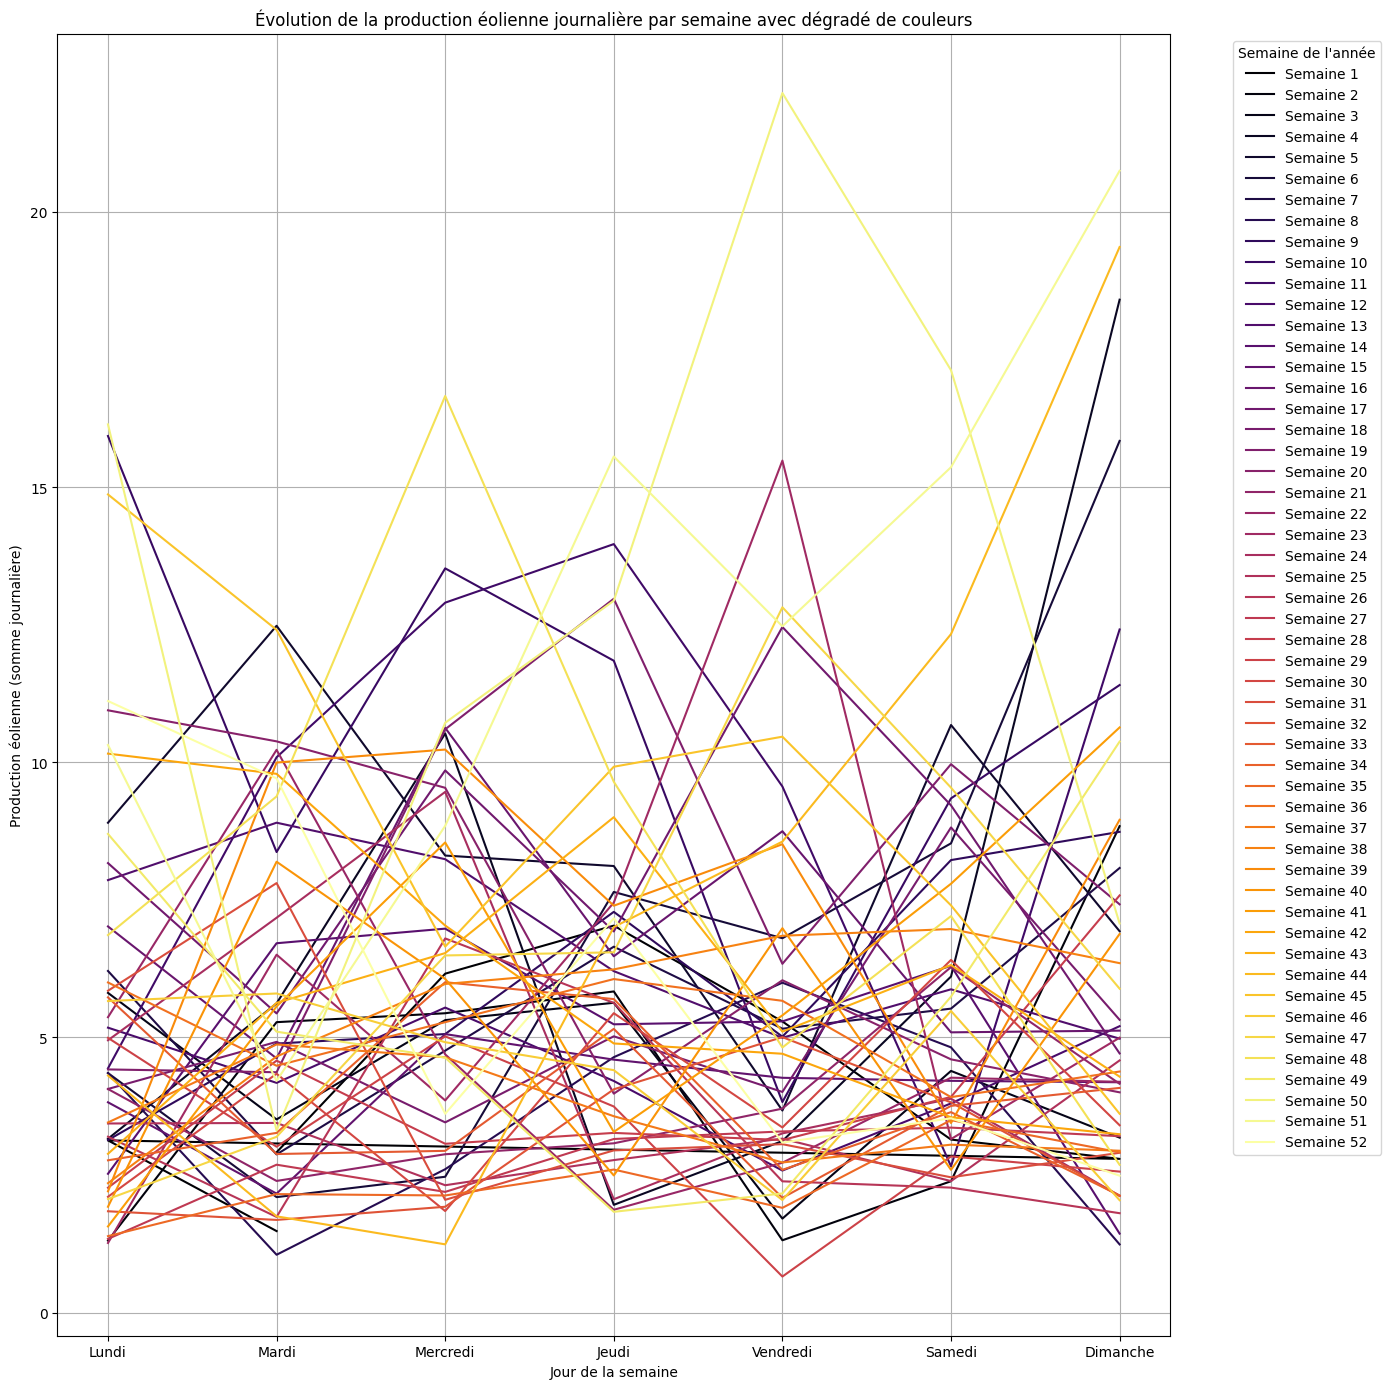

In [103]:
# Préparation du graphique avec un dégradé de couleurs pour les semaines
plt.figure(figsize=(14, 14))

# Définir un dégradé de couleurs pour les semaines
colors = plt.cm.inferno(np.linspace(0, 1, daily_production['week_of_year'].nunique()))

# Tracer une courbe pour chaque semaine avec un dégradé de couleurs
for i, week in enumerate(sorted(daily_production['week_of_year'].unique())):
    weekly_data = daily_production[daily_production['week_of_year'] == week]
    plt.plot(weekly_data['day_of_week'], weekly_data['electricity'], label=f'Semaine {week}', color=colors[i])

# Améliorer le graphique
plt.title('Évolution de la production éolienne journalière par semaine avec dégradé de couleurs')
plt.xlabel('Jour de la semaine')
plt.ylabel('Production éolienne (somme journalière)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Semaine de l'année")
plt.xticks(range(7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])

# Afficher le graphique
plt.tight_layout()
plt.grid()
plt.show()


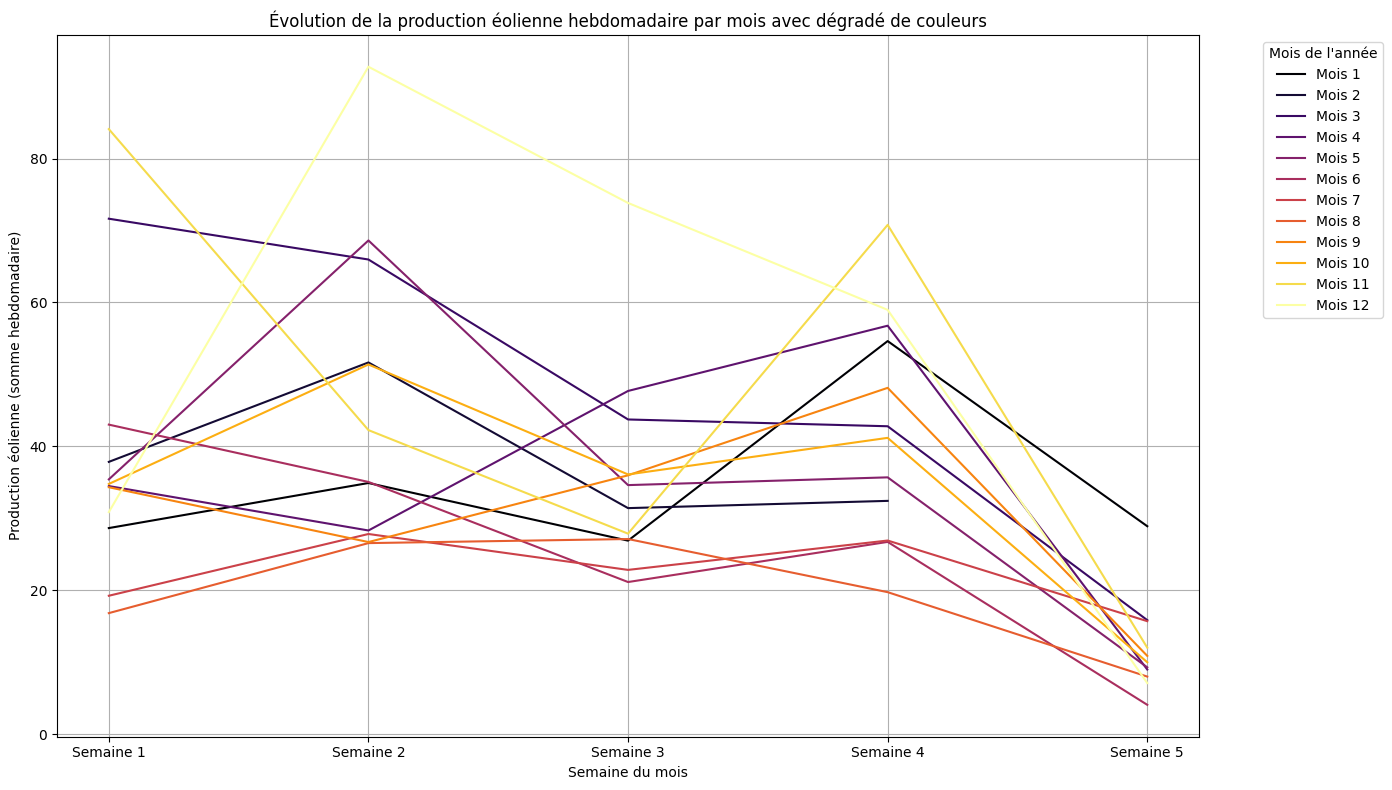

In [104]:
# Convertir la colonne 'time' en datetime
df['time'] = pd.to_datetime(df['time'])

# Créer une colonne 'date' avec la date extraite de 'time'
df['date'] = df['time'].dt.date

# Regrouper par 'date' et calculer la somme des productions
daily_production = df.groupby('date')['electricity'].sum().reset_index()

# Calculer le numéro de semaine de l'année et le jour de la semaine
daily_production['week_of_year'] = pd.to_datetime(daily_production['date']).dt.isocalendar().week
daily_production['day_of_week'] = pd.to_datetime(daily_production['date']).dt.dayofweek

# Ajouter une colonne pour le mois et une pour le numéro de la semaine dans le mois
daily_production['month'] = pd.to_datetime(daily_production['date']).dt.month
daily_production['week_of_month'] = daily_production['date'].apply(lambda d: (d.day-1)//7+1)

# Regrouper les données par mois et par semaine du mois pour obtenir la production totale hebdomadaire
weekly_production = daily_production.groupby(['month', 'week_of_month'])['electricity'].sum().reset_index()

plt.figure(figsize=(14, 8))

# Définir un dégradé de couleurs pour les mois
colors = plt.cm.inferno(np.linspace(0, 1, weekly_production['month'].nunique()))

# Tracer une courbe pour chaque mois avec un dégradé de couleurs
for i, month in enumerate(sorted(weekly_production['month'].unique())):
    monthly_data = weekly_production[weekly_production['month'] == month]
    plt.plot(monthly_data['week_of_month'], monthly_data['electricity'], label=f'Mois {month}', color=colors[i])

plt.title('Évolution de la production éolienne hebdomadaire par mois avec dégradé de couleurs')
plt.xlabel('Semaine du mois')
plt.ylabel('Production éolienne (somme hebdomadaire)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Mois de l'année")
plt.xticks(range(1, 6), ['Semaine 1', 'Semaine 2', 'Semaine 3', 'Semaine 4', 'Semaine 5'])

plt.tight_layout()
plt.grid()
plt.show()



Aucune saisonnalité n'est mise en évidence ici...

### Le bruit

Il ne reste plus qu'à identifier ce qu'il reste : le bruit. On l'obtient donc en soustrayant (dans un modèle additif !) à la série originale les tendance et saisonnalité.

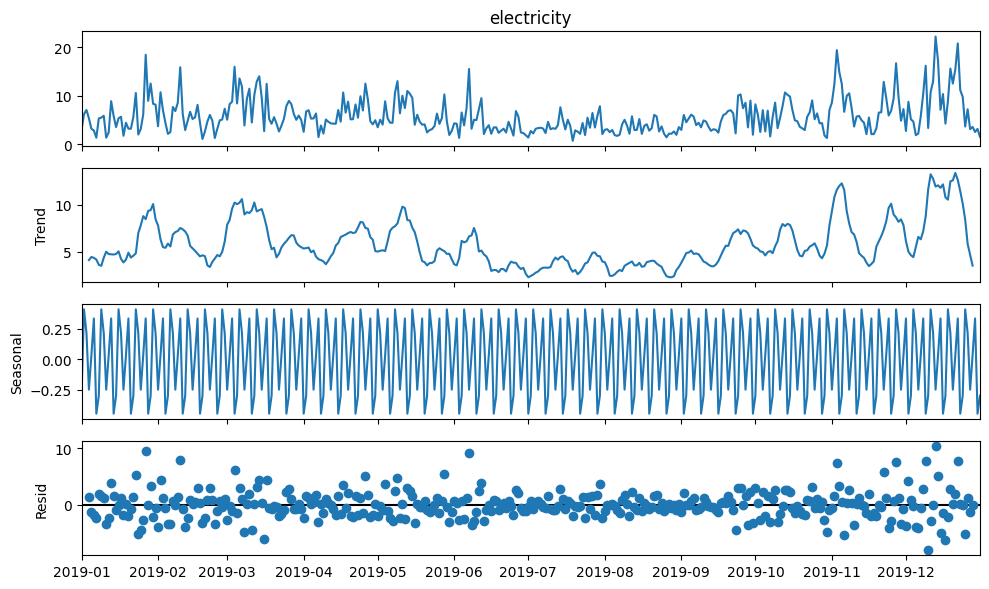

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
df_ = data_wind_na.set_index('time')['electricity'].resample('D').sum()

decomp = seasonal_decompose(df_, model='additive')

fig = decomp.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

## Prévision avec un lissage exponentiel

Le lissage exponentiel est une technique de lissage qui ressemble un peu aux moyennes mobiles. Cette méthode peut être utilisée pour prédire une série temporelle. C'est en fait un cas particulier des modèles ARMA. On en distingue différents types (simple, double, triple...).

Le lissage exponentiel triple ou méthode de Holt-Winters est adapté à des séries à tendance localement linéaire avec en plus une composante saisonnière. 

C:\Users\Manon Julia\AppData\Local\Temp\ipykernel_37760\3126669003.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax1.plot(pd.date_range(df_.index[len(df_)-1], periods=60, freq='M'), y_pred, label='Pred')


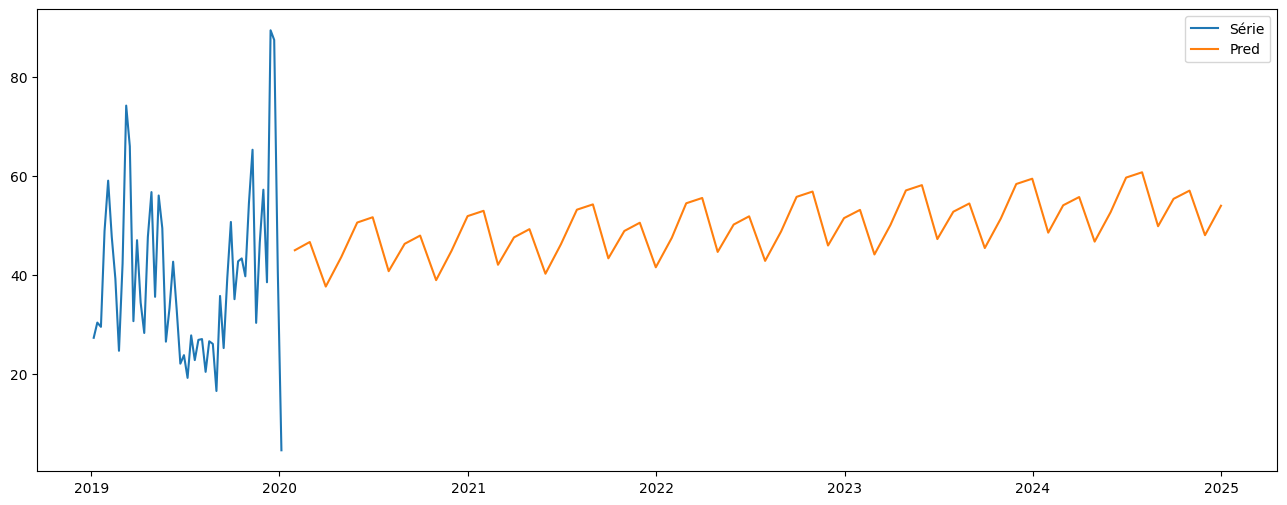

In [115]:
from statsmodels.tsa.api import ExponentialSmoothing

let = ExponentialSmoothing(df_.values, seasonal_periods=7, trend='add', seasonal='add').fit()

y_pred = let.forecast(60)# prédiction pour la série log
x_pred = np.exp(let.forecast(60)) # récupération des prédiction pour la série originale

fig, ax1 = plt.subplots(1, figsize=(16,6))

ax1.plot(df_, label='Série')
ax1.plot(pd.date_range(df_.index[len(df_)-1], periods=60, freq='M'), y_pred, label='Pred')
ax1.legend()

plt.show()

## Prévision à l'aide d'un modèle ARIMA

Ils sont utilisés dans certains cas où les données montrent une non-stationnarité. Une étape de différenciation initiale (correspondant à la partie "intégrée" du modèle) peut alors être appliquée une ou plusieurs fois afin d'éliminer la non-stationnarité. Dans le modèle de base, trois paramètres (p,d,q)
 sont utilisés pour caractériser les modèles ARIMA.

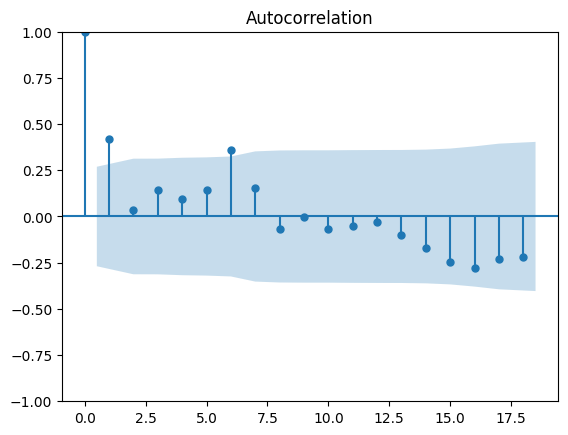

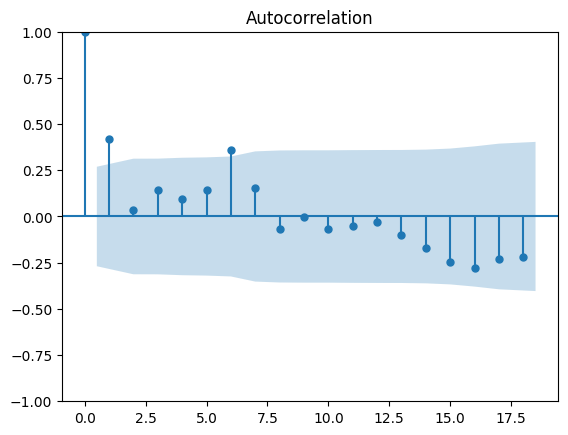

In [116]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_.values)

L'autocorrélation est un indicateur montrant comment les observations d'une série temporelle sont liées entre elles. Il s'agit de la corrélation entre la série et cette même série décalée dans le temps. Comme la corrélation, l'autocorrélation prend ses valeurs entre [−1,1]. Une valeur de 1 signifie que la série et la série décalée se superposent parfaitement.

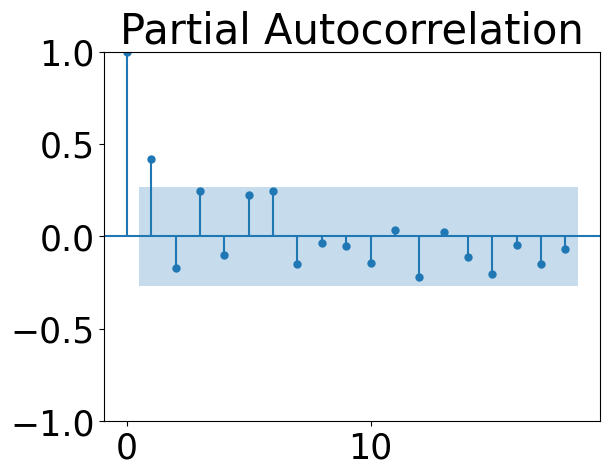

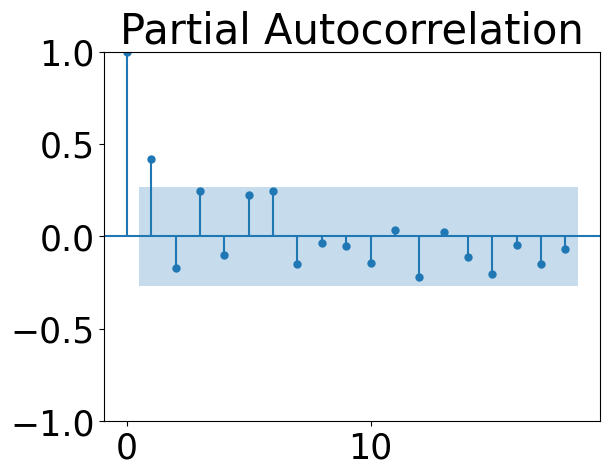

In [124]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_.values)

- ACF au décalage k = corrélation entre les valeurs séparées par k intervalles
- PACF au décalage k = corrélation entre les valeurs séparées par k intervalles, compte tenu des valeurs des intervalles intermédiaires

Lien utile : https://blog.statoscop.fr/timeseries-3.html#lautocorrelation-et-lautocorrelation-partielle

Lien utile : https://blog.statoscop.fr/timeseries-4.html#la-tendance


### Stationnarisation de la série


Les séries ont généralement une tendance et une saisonnalité toutefois afin de pouvoir les modéliser par des processus stationnaires comme les ARMA, il faut qu'elles soient stationnaires. Or elles ne le sont que rarement, il faut donc les stationnariser.